In [1]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 4.6MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 


In [2]:
# Downlod the dataset

! rm -rf data
! rm *.csv*
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_bert.csv
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_bert.csv
! mkdir -p data
! mv *.csv data/


rm: cannot remove '*.csv*': No such file or directory
--2020-08-01 05:37:36--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_bert.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16310138 (16M) [text/csv]
Saving to: ‘test_bert.csv’

test_bert.csv       100%[===================>]  15.55M  96.3MB/s    in 0.2s    

2020-08-01 05:37:37 (96.3 MB/s) - ‘test_bert.csv’ saved [16310138/16310138]

--2020-08-01 05:37:41--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_bert.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [3]:
import torch
from pytorch_pretrained_bert import BertModel
import csv
import numpy as np
from torch import nn
import math
import matplotlib.pyplot as plt

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
class BatchGenerator:

    def __init__(self, data_path, batch_size):
        self.batch_size = batch_size
        self.data_path = data_path
        self.n_labels = 20

    def get_batch_gen(self, repeat=True):
        while True:
            with open(self.data_path) as data_file:
                reader = csv.reader(data_file)
                batch = []
                for row in reader:  # TODO: Can the next batch be fetched asynchronously? With asyncio?
                    batch.append(row)
                    if len(batch) >= self.batch_size:
                        batch = self._split_batch(batch)
                        yield batch
                        batch = []
                if 0 < len(batch) < self.batch_size:
                    yield self._split_batch(batch)
            if not repeat:
                break

    def _split_batch(self, batch):
        batch = np.array(batch, dtype=int)
        x = batch[:, :len(batch[0]) - self.n_labels]
        y = batch[:, len(batch[0]) - self.n_labels:]
        return x, y


In [6]:
class BertEmailClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertEmailClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 20)

    def forward(self, x, masks=None):
        _, x = self.bert(x, attention_mask=masks, output_all_encoded_layers=False)
        x = self.dropout(x)
        x = nn.functional.softmax(self.linear(x), dim=1)
        return x

bert_clf = BertEmailClassifier().to(device)
optim = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)


100%|██████████| 407873900/407873900 [00:10<00:00, 39108281.90B/s]


In [7]:
train_batch_size = 10
test_batch_size = 5
train_size = 11083
test_size = 7761
train_steps = train_size / train_batch_size
test_steps = test_size / test_batch_size

train_gen = BatchGenerator(data_path='data/train_bert.csv', batch_size=train_batch_size).get_batch_gen()
test_gen = BatchGenerator(data_path='data/test_bert.csv', batch_size=test_batch_size).get_batch_gen()

In [8]:
train_steps

1108.3

In [9]:
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
torch.cuda.empty_cache()
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

439.123456M
439.123456M


In [10]:
class Metrics:
    def __init__(self):
        self.losses = []
        self.accuracies = []

        self._epoch_loss = 0
        self._epoch_accuracy = 0

        self.n_batches = 0
        self.n_epochs = 0

    def record_batch(self, loss, accuracy):
        self.n_batches += 1
        self._epoch_loss += loss
        self._epoch_accuracy += accuracy

    def record_epoch(self):
        self.losses.append(self._epoch_loss/self.n_batches)
        self.accuracies.append(self._epoch_accuracy/self.n_batches)

        self.n_epochs += 1
        self._epoch_loss = 0
        self._epoch_accuracy = 0
        self.n_batches = 0

    @staticmethod
    def find_accuracy(y_hat, y_real):
        max_args_equals = torch.argmax(y_hat, dim=1) == torch.argmax(y_real, dim=1)
        return sum([1 if value else 0 for value in max_args_equals]) / len(y_hat)


In [11]:
def record_test_metrics(metrics):
    bert_clf.eval()
    with torch.no_grad():
        for batch_i in range(math.ceil(test_steps)):

            x_batch, y_batch = next(test_gen)
            x_batch = torch.tensor(x_batch).to(device)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
            x_batch_masks = torch.tensor([[float(i > 0) for i in ii] for ii in x_batch]).to(device)

            y_hat = bert_clf(x_batch, x_batch_masks)

            loss = nn.functional.binary_cross_entropy(y_hat, y_batch)

            metrics.record_batch(loss.item(), Metrics.find_accuracy(y_hat, y_batch))

            if batch_i % 200 == 0:
                print(loss.item())

        metrics.record_epoch()

In [12]:
train_metrics = Metrics()
test_metrics = Metrics()

In [13]:
def train(epochs, train_metrics, test_metrics):

    for epoch in range(epochs):

        for batch_i in range(math.ceil(train_steps)):

            x_batch, y_batch = next(train_gen)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
            x_batch_masks = torch.tensor([[float(i > 0) for i in ii] for ii in x_batch]).to(device)
            x_batch = torch.tensor(x_batch).to(device)

            optim.zero_grad()

            y_hat = bert_clf(x_batch, x_batch_masks)

            loss = nn.functional.binary_cross_entropy(y_hat, y_batch)

            loss.backward()
            optim.step()

            train_metrics.record_batch(loss.item(), Metrics.find_accuracy(y_hat, y_batch))

            if batch_i % 200 == 0:
                print(loss.item())

        train_metrics.record_epoch()
        record_test_metrics(test_metrics)

        print(f'Epoch: {epoch}, train_loss={train_metrics.losses[-1]}, train_accuracy={train_metrics.accuracies[-1]}, val_loss={test_metrics.losses[-1]}, val_accuracy={test_metrics.accuracies[-1]}')

train(7, train_metrics, test_metrics)

0.2024816870689392
0.18500015139579773
0.1506507694721222
0.13745072484016418
0.11775776743888855
0.11297935247421265
0.09622488170862198
0.08227772265672684
0.11618775874376297
0.08756206929683685
0.09415136277675629
0.09082947671413422
0.08744733780622482
0.08624626696109772
Epoch: 0, train_loss=0.14828684555183563, train_accuracy=0.48999098286744885, val_loss=0.09973225612565155, val_accuracy=0.7294269156471274
0.10116111487150192
0.08822470158338547
0.05261806398630142
0.04719800874590874
0.05465045943856239
0.06227647140622139
0.05608008801937103
0.02660210058093071
0.08267854154109955
0.025071796029806137
0.040913231670856476
0.04748505353927612
0.053673695772886276
0.03555981442332268
Epoch: 1, train_loss=0.06798594857660954, train_accuracy=0.8108205590622116, val_loss=0.06148046409952318, val_accuracy=0.8038634900193067
0.06791946291923523
0.0548502616584301
0.026279818266630173
0.02252727374434471
0.022704806178808212
0.032037023454904556
0.05669257044792175
0.0094277160242199

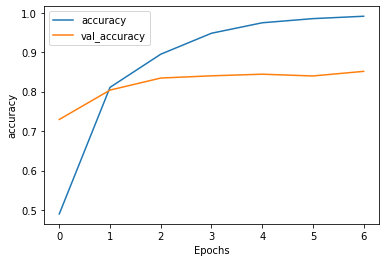

In [14]:
plt.plot(train_metrics.accuracies)
plt.plot(test_metrics.accuracies)
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

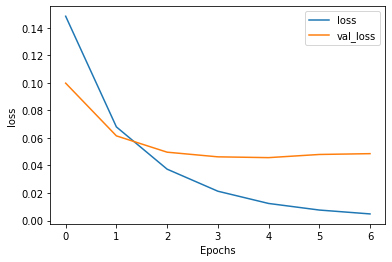

In [15]:
plt.plot(train_metrics.losses)
plt.plot(test_metrics.losses)
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [16]:
torch.save(bert_clf, 'bert_clf.pt')

In [17]:
from google.colab import files
files.download('bert_clf.pt')

FileNotFoundError: ignored

In [ ]:
from google.colab import files
files.download('bert_clf2.pt')

In [1]:
!ls

sample_data
